AAPL     0.338744
AMZN     0.165084
AVGO     0.486242
BRK-B    0.172140
GOOG     0.224226
JPM      0.157192
LLY      0.533718
META     0.263814
MSFT     0.265094
NVDA     0.947882
PG       0.095326
TSLA     0.747428
UNH      0.236904
V        0.106120
XOM      0.162699
dtype: float64
                AAPL      AMZN      AVGO     BRK-B      GOOG       JPM  \
date                                                                     
2019-10-31  0.110684  0.023475  0.060782  0.021921  0.033724  0.069948   
2019-11-30  0.077517  0.013587  0.079768  0.036316  0.035592  0.054755   
2019-12-31  0.098784  0.026122  0.009581  0.028143  0.024568  0.057984   
2020-01-31  0.054010  0.087064 -0.034365 -0.009139  0.072706 -0.044325   
2020-02-29 -0.114673 -0.062214 -0.106633 -0.080604 -0.066168 -0.122771   

                 LLY      META      MSFT      NVDA        PG      TSLA  \
date                                                                     
2019-10-31  0.018957  0.076202  0.031216  0.1548

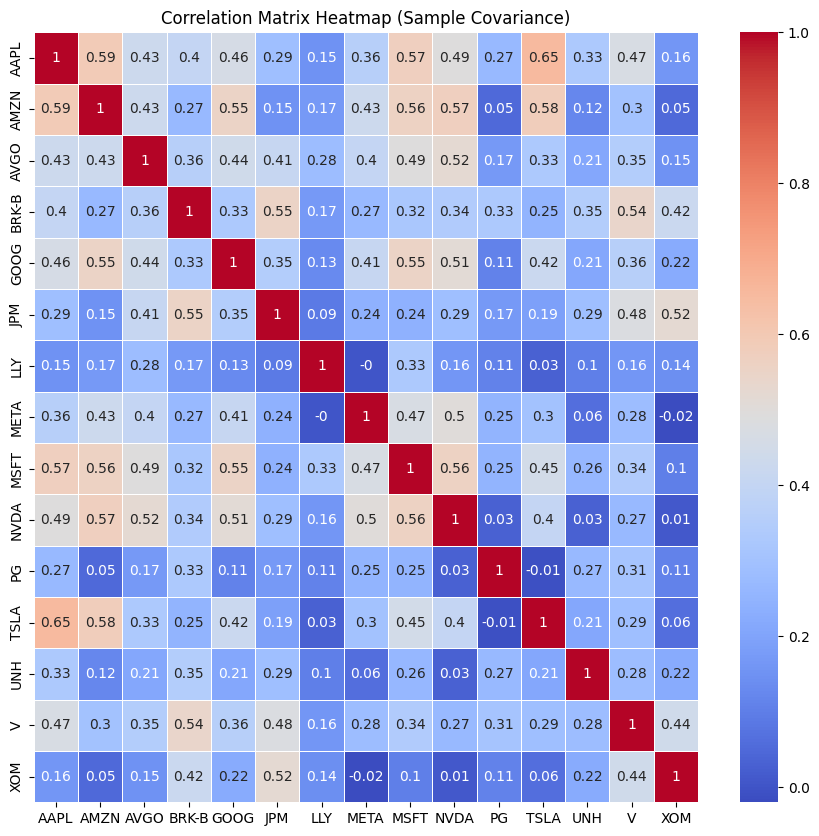

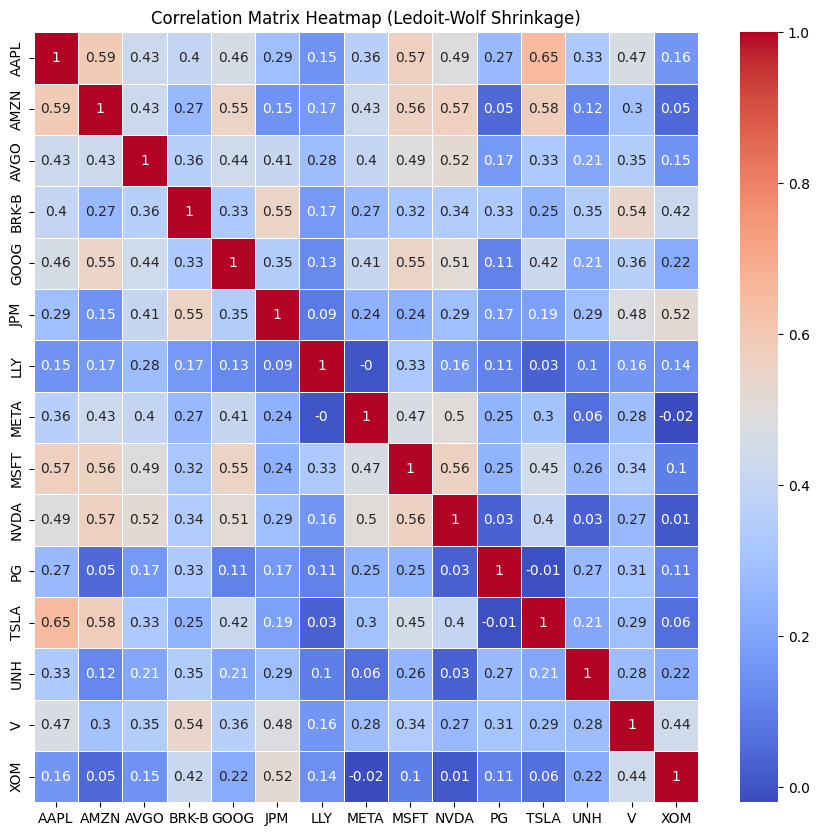

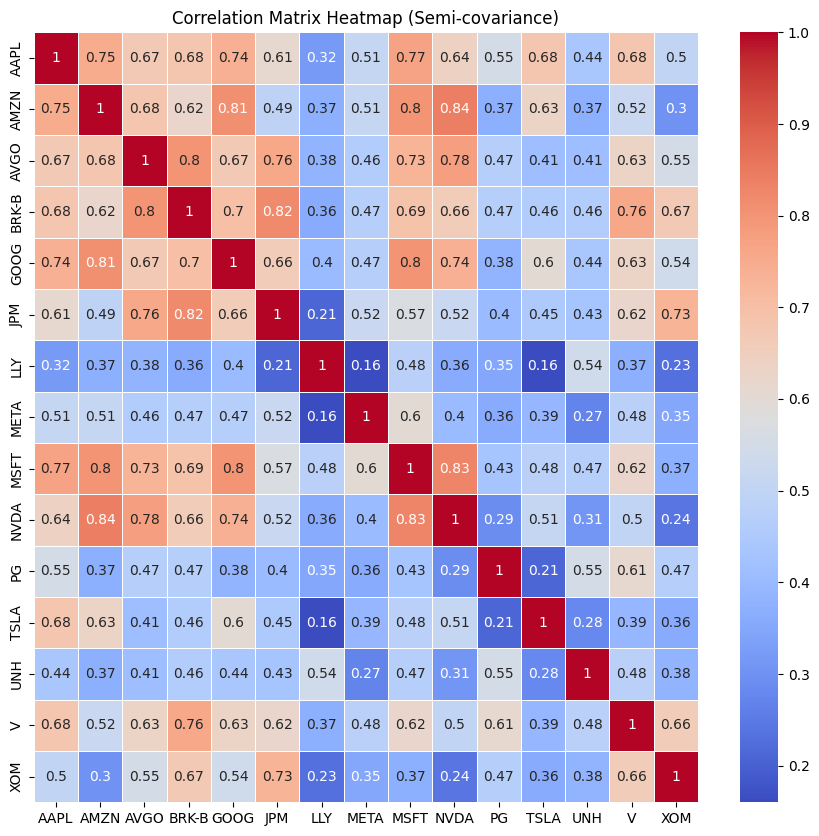

In [6]:
'''
Generate covariance/semicovariance matrices and correlations.
'''

# required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier, EfficientSemivariance, base_optimizer


# Load prices
prices = pd.read_csv('prices.csv')
prices.set_index('date', inplace=True)
prices.index = pd.to_datetime(prices.index)

# Calculate monthly prices, returns and expected returns 
monthly_prices = prices.resample('ME').last()  # Resample to get monthly prices
monthly_returns = monthly_prices.pct_change().dropna()
mu = expected_returns.mean_historical_return(monthly_prices, frequency=12)
print(mu)
print(monthly_returns.head())

# Calculate covariance matrices
cov_sample = risk_models.sample_cov(monthly_prices, frequency=12) # inclusion in output only. Easy to understand method
cov_sample = risk_models.CovarianceShrinkage(monthly_prices, frequency=12).ledoit_wolf()
semivarcov = risk_models.semicovariance(monthly_prices, benchmark=0.0, frequency=12)

# Convert covariance matrices to correlation matrices
def calculate_correlation(cov_matrix):
    variances = np.diag(cov_matrix) 
    std_dev = np.sqrt(variances)
    sd_df = pd.Series(std_dev, index=cov_matrix.index)

    # Divide by sd. to get correlation
    corr_matrix = cov_matrix.divide(sd_df, axis=0)  
    corr_matrix = corr_matrix.divide(sd_df, axis=1)

    # Round output to 2dp
    corr_matrix = corr_matrix.round(2)

    return corr_matrix

corr_sample = calculate_correlation(cov_sample)
corr_ledoit = calculate_correlation(cov_sample)
corr_semicov = calculate_correlation(semivarcov)
print(corr_sample.head())


# # Plotting the correlation matrices as heatmaps
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_sample, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix Heatmap (Sample Covariance)')
# plt.show()
# plt.savefig('correlation_heatmap.png')

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_ledoit, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix Heatmap (Ledoit-Wolf Shrinkage)')
# plt.show()
# plt.savefig('correlation_heatmap_ledoit.png')

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_semicov, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix Heatmap (Semi-covariance)')
# plt.show()
# plt.savefig('correlation_heatmap_semivar.png')


# Reorganised heatmap generation as a function, dynamic sizing
def plot_correlation_heatmap(corr_matrix, title, filename):
    plt.figure(figsize=((len(corr_matrix) / 1.4), (len(corr_matrix) / 1.5)) )
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Correlation Matrix Heatmap ({title})')
    plt.savefig(filename)
    plt.show()

plot_correlation_heatmap(corr_sample, 'Sample Covariance', 'correlation_heatmap_sample.png')
plot_correlation_heatmap(corr_ledoit, 'Ledoit-Wolf Shrinkage', 'correlation_heatmap_ledoit.png')
plot_correlation_heatmap(corr_semicov, 'Semi-covariance', 'correlation_heatmap_semivar.png')


In [7]:
'''
Portfolio Optimisations. 
EW / Max Sharpe / Markowitz / Min Vol / Semivar / Max Sortino 
'''

# Other variables
annual_risk_free = 0.02 # standard default. Is this ok, or should it be adjusted? 
inflation_plus = 0.09 # TODO: pull CPI data for the input period and get annual number. CPI+5% (real return equity target)
assets = len(monthly_prices.columns)
max_weight = (1 / assets) * 2


# Equal Weighted Portfolio
ew = np.array([1/assets] * assets)
stock_ew = round(1 / assets, 5)
equal_weight_dict = {ticker: stock_ew for ticker in monthly_prices.columns}
ef_ew = EfficientFrontier(mu,cov_sample)
ef_ew.set_weights(equal_weight_dict)
equal_weight_dict = ef_ew.clean_weights()
print(f"Equal Weighted Portfolio:")
print(equal_weight_dict)
ew_performance = ef_ew.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)


# Max Sharpe Ratio Portfolio
ef_sharpe = EfficientFrontier(mu, cov_sample, weight_bounds=(0.01, max_weight))
ef_sharpe.max_sharpe(risk_free_rate=annual_risk_free)
max_sharpe_weights = ef_sharpe.clean_weights()
print(f"Max Sharpe Portfolio:")
print(max_sharpe_weights)
max_sharpe_performance = ef_sharpe.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)


# Efficient Return - 'Markowitz portfolio'
ef_markowitz = EfficientFrontier(mu, cov_sample, weight_bounds=(0.01, max_weight))
ef_markowitz.efficient_return(target_return=inflation_plus)
max_ef_markowitz_weights = ef_markowitz.clean_weights()
print(f"Markowitz Portfolio:")
print(max_ef_markowitz_weights)
markowitz_performance = ef_markowitz.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)


# Minimum Volatility Portfolio
ef_min_vol = EfficientFrontier(mu, cov_sample, weight_bounds=(0.01, max_weight))
ef_min_vol.min_volatility()
min_vol_weights = ef_min_vol.clean_weights()
print(f"Minimum Vol Portfolio:")
print(min_vol_weights)
min_vol_performance = ef_min_vol.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)


# Semivariance - Minimise Semivariance
svo_historic_returns = expected_returns.returns_from_prices(monthly_prices)
svo = EfficientSemivariance(mu, svo_historic_returns, frequency=12, weight_bounds=(0.01, max_weight))
svo.min_semivariance()
svoweights = svo.clean_weights()
print(f"Minimum Semivar Portfolio:")
print(svoweights)
svo_performance = svo.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)

# PMPT - Optimise for Sortino Ratio
# Heuristic method - suggested from https://github.com/robertmartin8/PyPortfolioOpt/issues/401
inflation_plus_monthly = (1 + inflation_plus) ** (1/12) - 1 # requires monthly MAR
semivarcov = risk_models.semicovariance(monthly_prices, benchmark=inflation_plus_monthly, frequency=12)
pmpt = ef_min_vol = EfficientFrontier(mu, semivarcov, weight_bounds=(0.01, max_weight))
pmpt.max_sharpe(risk_free_rate=annual_risk_free)
pmpt_weights = pmpt.clean_weights()
print(pmpt_weights)
svo.set_weights(pmpt_weights) # 'hack' to generate sortino ratio to save having to recalculate
pmpt_performance = svo.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)
print(pmpt_performance)

# Combine to dataframe
ew_series = pd.Series(equal_weight_dict, name='Equal Weights (%)')
max_sharpe_series = pd.Series(max_sharpe_weights, name='Max Sharpe Weights (%)')
markowitz_series = pd.Series(max_ef_markowitz_weights, name='Markowitz Weights (%)')
min_vol_series = pd.Series(min_vol_weights, name='Min Vol Weights (%)')
svo_series = pd.Series(svoweights, name="Min Semivariance (%)")
pmpt_series = pd.Series(pmpt_weights, name="Max Sortino (%)")
weights_df = pd.concat([ew_series, max_sharpe_series, markowitz_series, min_vol_series, svo_series, pmpt_series], axis=1)
print(weights_df)



Equal Weighted Portfolio:
OrderedDict({'AAPL': 0.06667, 'AMZN': 0.06667, 'AVGO': 0.06667, 'BRK-B': 0.06667, 'GOOG': 0.06667, 'JPM': 0.06667, 'LLY': 0.06667, 'META': 0.06667, 'MSFT': 0.06667, 'NVDA': 0.06667, 'PG': 0.06667, 'TSLA': 0.06667, 'UNH': 0.06667, 'V': 0.06667, 'XOM': 0.06667})
Expected annual return: 32.7%
Annual volatility: 19.4%
Sharpe Ratio: 1.58
Max Sharpe Portfolio:
OrderedDict({'AAPL': 0.04286, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.02558, 'GOOG': 0.01, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.0736, 'NVDA': 0.13333, 'PG': 0.13333, 'TSLA': 0.03895, 'UNH': 0.13333, 'V': 0.01, 'XOM': 0.10234})
Expected annual return: 40.0%
Annual volatility: 18.1%
Sharpe Ratio: 2.11
Markowitz Portfolio:
OrderedDict({'AAPL': 0.01, 'AMZN': 0.02975, 'AVGO': 0.01, 'BRK-B': 0.13333, 'GOOG': 0.06506, 'JPM': 0.05182, 'LLY': 0.13333, 'META': 0.01406, 'MSFT': 0.12412, 'NVDA': 0.01, 'PG': 0.13333, 'TSLA': 0.01, 'UNH': 0.13333, 'V': 0.07609, 'XOM': 0.06577})
Expected annual return: 24.7

Data saved to Optimisation Output File.xlsx


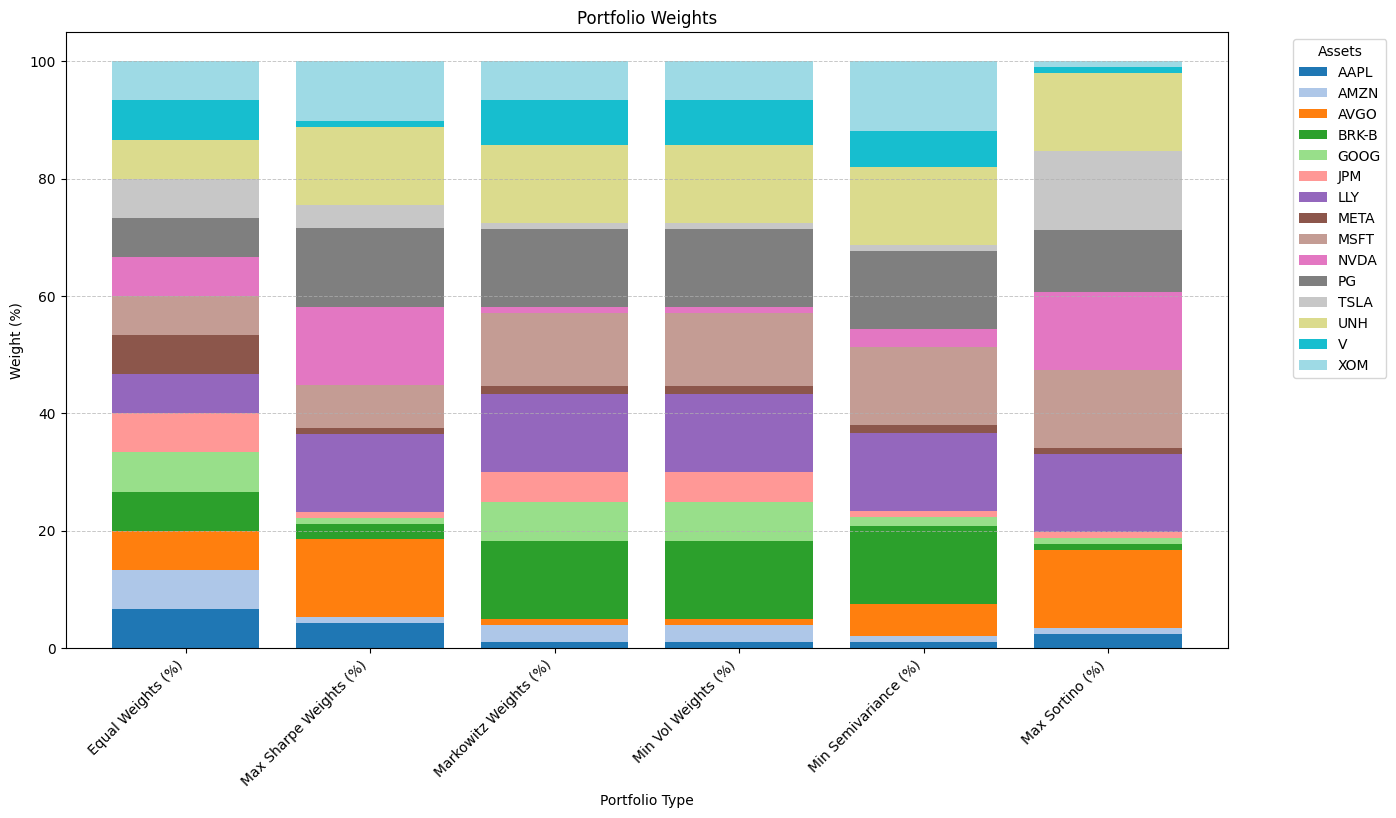

In [8]:
'''
Save data to excel: Correlation matrices, portfolio weights, monthly returns. 

'''

# additional libraries
import openpyxl


output_filename = 'Optimisation Output File.xlsx'
with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
    
    # Write correlation matrices
    corr_sample.to_excel(writer, sheet_name='Correlation Sample')
    corr_ledoit.to_excel(writer, sheet_name='Correlation Ledoit-Wolf')
    corr_semicov.to_excel(writer, sheet_name='Correlation Semicov')

    # Format the correlations to a more readable size. 
    workbook = writer.book
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        for row in worksheet.iter_rows():
            for cell in row:
                cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
        for col in range(1, worksheet.max_column + 1):
            col_letter = openpyxl.utils.get_column_letter(col)
            worksheet.column_dimensions[col_letter].width = 7.5
        for row in range(1, worksheet.max_row + 1):
            worksheet.row_dimensions[row].height = 39

        # Add conditional formatting 
        color_scale_rule = openpyxl.formatting.rule.ColorScaleRule(start_type='num', start_value=0, start_color='0000FF',
                                                                   mid_type='num', mid_value=0.5, mid_color='FFFFFF',
                                                                   end_type='num', end_value=1, end_color='FF0000')
        worksheet.conditional_formatting.add(f'A1:{openpyxl.utils.get_column_letter(worksheet.max_column)}{worksheet.max_row}', color_scale_rule)

    # Write optimised weights
    weights_df.to_excel(writer, sheet_name='Portfolio Weights')
    workbook = writer.book
    worksheet = writer.sheets['Portfolio Weights']
    for row in range(2, 2 + weights_df.shape[0]):
        for col in range(2, 2 + weights_df.shape[1]):
            cell = worksheet.cell(row=row, column=col)
            cell.number_format = '0.00%'
    for col in range(2, worksheet.max_column + 1):
        col_letter = openpyxl.utils.get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = 20 

    # Write monthly security returns
    monthly_returns.to_excel(writer, sheet_name='Security Returns')
    worksheet = writer.sheets['Security Returns']
    for cell in worksheet['A']:  
        if cell.row > 1: 
            cell.number_format = 'yyyy-mm-dd'
    
print(f'Data saved to {output_filename}')

# Comparative plot of optimised portfolio weights. 
def plot_portfolio_weights(weights_df):
    # Normalize weights to sum to 100% for each portfolio type
    weights_df = weights_df.div(weights_df.sum(axis=0), axis=1) * 100
    weights_df = weights_df.T
    weights_df.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8, colormap='tab20')

    # Add titles and labels for clarity
    plt.title("Portfolio Weights")
    plt.xlabel("Portfolio Type")
    plt.ylabel("Weight (%)")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Assets", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Display the plot
    plt.show()

plot_portfolio_weights(weights_df)
